# 2017 패션 트렌드 분석

## 형태소 분석

In [1]:
from konlpy.tag import Twitter

In [2]:
tagger = Twitter() 

## 패션 매거진 가져오기

In [3]:
from urllib.parse import quote_plus

import requests
import lxml.html

In [4]:
query = '트렌드'

In [5]:
url = 'http://www.fashionseoul.com/page/{page}?s={query}'

In [6]:
articles = []
for page in range(1, 4):
    search_url = url.format(query=query, page=page)
    res = requests.get(search_url)
    root = lxml.html.fromstring(res.text)
    for link in root.cssselect('h3 a'):  # 링크 추출
        news = requests.get(link.attrib['href'])
        news_root = lxml.html.fromstring(news.text)
        article = news_root.cssselect('#the-post > div.entry-content.entry.clearfix')[0]  # 본문 추출
        text = article.text_content()
        articles.append(text)

In [7]:
len(articles)

39

## 문제점 및 해결

주제가 패션 트렌드 분석인데 모집단이 될 데이터들의 시기를 어느 시점으로 정해야 할지 고민이 되었습니다.왜냐하면
최근 2,3개년의 데이터들을 불러왔을 경우에 출력되는 단어들은 너무 구분이 모호하고 카테고리의 범위가 큰 단어들이었기 때문이었습니다.
(ex 패션,트렌드,쇼핑 등과 같은 단어들)


-> 기간을 17년으로 한정지어 출력한 결과 유의미한 데이터들을 얻을 수 있게 되었습니다.

## 한국어 Term-Document Matrix 만들기

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

In [9]:
def get_noun(text):
    nouns = tagger.nouns(text)
    return [n for n in nouns if len(n) > 1]  # 2글자 이상인 명사만 추출

In [10]:
cv = CountVectorizer(tokenizer=get_noun, max_features=100)

In [11]:
tdm = cv.fit_transform(articles)

## 빈도순 단어 보기

In [12]:
import numpy

In [13]:
import operator

In [14]:
words = cv.get_feature_names()

In [15]:
count_mat = tdm.sum(axis=0)

In [16]:
count = numpy.squeeze(numpy.asarray(count_mat))

In [17]:
word_count = list(zip(words, count))

In [18]:
word_count = sorted(word_count, key=operator.itemgetter(1), reverse=True)

In [19]:
word_count

[('패션', 289),
 ('상품', 244),
 ('판매', 187),
 ('브랜드', 164),
 ('가격', 154),
 ('인공', 149),
 ('온라인', 148),
 ('지능', 143),
 ('회사', 141),
 ('트렌드', 110),
 ('컴퓨터', 105),
 ('통해', 97),
 ('디자인', 95),
 ('우리', 92),
 ('매장', 91),
 ('고양이', 90),
 ('학습', 90),
 ('고객', 89),
 ('스타일', 87),
 ('컬러', 87),
 ('바로', 75),
 ('경우', 74),
 ('매출', 74),
 ('백화점', 74),
 ('업계', 74),
 ('인간', 74),
 ('소재', 73),
 ('아이템', 72),
 ('인턴', 72),
 ('때문', 71),
 ('본사', 70),
 ('물론', 69),
 ('제품', 69),
 ('대한', 67),
 ('대리점', 66),
 ('소비자', 59),
 ('시즌', 57),
 ('유통', 57),
 ('결과', 54),
 ('데이터', 54),
 ('가지', 53),
 ('환경', 53),
 ('하나', 52),
 ('년대', 49),
 ('사입', 48),
 ('아이', 47),
 ('이미지', 47),
 ('비즈니스', 46),
 ('세대', 46),
 ('오프라인', 46),
 ('여성', 45),
 ('분석', 44),
 ('버킷', 43),
 ('이번', 43),
 ('이야기', 43),
 ('기획', 42),
 ('자신', 42),
 ('중심', 42),
 ('다운', 41),
 ('사람', 41),
 ('시대', 41),
 ('의류', 41),
 ('인기', 41),
 ('정도', 40),
 ('재고', 39),
 ('출시', 39),
 ('가장', 38),
 ('대표', 38),
 ('생활', 38),
 ('쇼핑몰', 38),
 ('느낌', 37),
 ('최근', 37),
 ('카드', 37),
 ('사실', 36),
 ('과거', 

## Word Cloud

In [20]:
%matplotlib inline

In [21]:
from matplotlib import pyplot
from wordcloud import WordCloud

In [22]:
wc = WordCloud(font_path='C:\\Windows\\Fonts\\YDWM05.ttf', background_color='white', width=400, height=300)

In [23]:
cloud = wc.fit_words(dict(word_count))

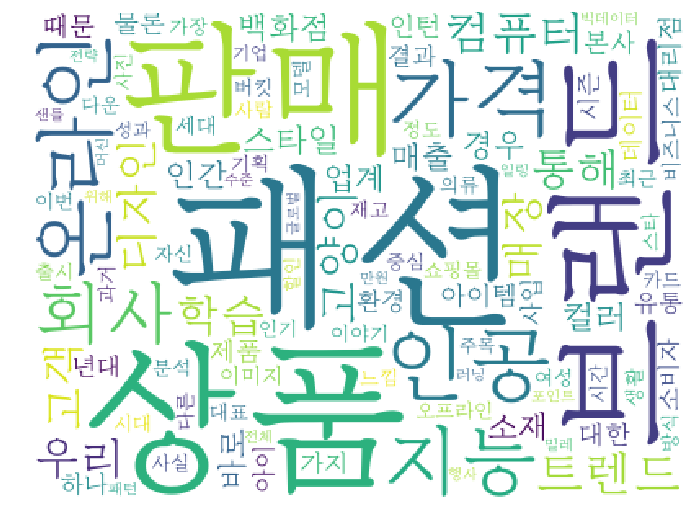

In [24]:
pyplot.figure(figsize=(12, 9))
pyplot.imshow(cloud)
pyplot.axis("off")
pyplot.show()

## gensim 포맷으로 바꾸기

In [25]:
from gensim.matutils import Sparse2Corpus

C:\Users\Kim Seok Joon\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [26]:
corpus = Sparse2Corpus(tdm.T)

In [27]:
corpus

## Latent Dirichlet Allocation

In [28]:
from gensim.models.ldamodel import LdaModel

In [29]:
lda = LdaModel(corpus=corpus, num_topics=100, id2word=dict(enumerate(words)), random_state=1234)

## Topic 보기

In [30]:
lda.show_topic(0)

[('버킷', 0.079241334475999348),
 ('다운', 0.074370357713659838),
 ('디자인', 0.059676727700833029),
 ('출시', 0.055208999793026861),
 ('가격', 0.047632489873596737),
 ('브랜드', 0.042280515115156084),
 ('업계', 0.038702929807841686),
 ('트렌드', 0.034334239807968556),
 ('아이템', 0.032446836731181629),
 ('최근', 0.031563642010976931)]

## 문서의 topic 확인

### 문서 변환

In [31]:
doc = [(i, tdm[0, i]) for i in range(100)]

### 문서에서 가장 많이 쓰인 단어들 보기

In [32]:
from operator import itemgetter

In [33]:
doc_words = [(words[i], n) for i, n in doc]

In [34]:
sorted(doc_words, key=itemgetter(1), reverse=True)[:10]

[('여성', 3),
 ('트렌드', 3),
 ('물론', 2),
 ('브랜드', 2),
 ('인기', 2),
 ('컬러', 2),
 ('포인트', 2),
 ('가격', 1),
 ('가지', 1),
 ('경우', 1)]

### 문서의 topic

In [35]:
lda.get_document_topics(doc)

[(45, 0.70123352600483724),
 (50, 0.10866810142250041),
 (69, 0.15665009671059077)]

In [36]:
lda.show_topic(7)

[('소재', 0.1822803062502279),
 ('트렌드', 0.16251790118704157),
 ('생활', 0.14232539637655803),
 ('글로벌', 0.12635496851763131),
 ('시즌', 0.060104622766937274),
 ('패션', 0.033353916793406178),
 ('이번', 0.023573834200434105),
 ('컬러', 0.023471274945861778),
 ('패턴', 0.02326889697403765),
 ('사람', 0.022956304296024417)]

In [37]:
lda.show_topic(40)

[('인간', 0.0099999999999999967),
 ('인공', 0.0099999999999999967),
 ('이미지', 0.0099999999999999967),
 ('이번', 0.0099999999999999967),
 ('이야기', 0.0099999999999999967),
 ('유통', 0.0099999999999999967),
 ('일링', 0.0099999999999999967),
 ('인턴', 0.0099999999999999967),
 ('우리', 0.0099999999999999967),
 ('인기', 0.0099999999999999967)]

## LDA 모델 저장하기

In [38]:
lda.save('20171103.lda')

## LDA 모델 불러오기

In [39]:
lda = LdaModel.load('20171103.lda')

In [40]:
lda.show_topic(0)

[('버킷', 0.079241334475999348),
 ('다운', 0.074370357713659838),
 ('디자인', 0.059676727700833029),
 ('출시', 0.055208999793026861),
 ('가격', 0.047632489873596737),
 ('브랜드', 0.042280515115156084),
 ('업계', 0.038702929807841686),
 ('트렌드', 0.034334239807968556),
 ('아이템', 0.032446836731181629),
 ('최근', 0.031563642010976931)]